# Obtain all neccessary imports

In [35]:
from IPython import get_ipython;   
import numpy as np
import random
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from numpy import dot, multiply, diag, power
from matplotlib.animation import FuncAnimation
from matplotlib import colors
from matplotlib import animation
from IPython.display import display, HTML

In [36]:
# Add path to the save folder on this system
# Add path to the save folder on this system
if os.name == 'nt':  # Windows
    folder_path = r'C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data'
    sim_folder_path = r"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data\simulationResults\Supplement"
else:  # macOS/Linux
    folder_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data'
    sim_folder_path = r'/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/simulationResults/Mayesha0512'


# Create the pouch class and pouch operations

In [37]:
class Pouch(object): 
    def __init__(self, params=None, size = 'small', sim_number=0, save=False, saveName='default'):
        
        """Class implementing pouch structure and simulating Calcium signaling.
        Inputs:
        
        params (dict)
            A Python dictionary of parameters to simulate with the keys:
            ['K_PLC', 'K_5', 'k_1' , 'k_a', 'k_p', 'k_2', 'V_SERCA', 'K_SERCA', 'c_tot', 'beta', 'k_i', 'D_p', 'tau_max', 'k_tau', 'lower', 'upper','frac', 'D_c_ratio']
        
        size (string)
            Size of the pouch to simulate:
            [xsmall, small, medium, or large]
        
        sim_number (integer)
            Represents ID of a simulation to save the figures with unique names and set the random number generator seed
        
        save (boolean)
            If True, the simulation outputs will be saved
        
        saveName (string)
            Additional distinct name to save the output files as
        
        """
        # Create characteristics of the pouch object
        self.size=size
        self.saveName=saveName
        self.sim_number=sim_number
        self.save=save
        self.param_dict=params
        
        # If parameters are not set, then use baseline values
        if self.param_dict==None:
            self.param_dict={'K_PLC': 0.2, 'K_5':0.66, 'k_1':1.11 , 'k_a': 0.08, 'k_p':0.13, 'k_2':0.0203, 'V_SERCA':0.9, 'K_SERCA':0.1,
            'c_tot':2, 'beta':.185, 'k_i':0.4, 'D_p':0.005, 'tau_max':800, 'k_tau':1.5, 'lower':0.5, 'upper':0.7, 'frac':0.007680491551459293, 'D_c_ratio':0.1,
            'alpha':0.025, 'Imax': 1, 'g_vgcc': 0.1, 'Ca_ext': 150, 'K_opt': 0.1, 'sim_time': 3600} 
        # If a dictionary is given, assure all parameters are provided
        required_params = ['D_c_ratio', 'D_p', 'K_5', 'K_PLC', 'K_SERCA', 'V_SERCA', 'beta', 'c_tot', 'frac', 
                   'k_1', 'k_2', 'k_a', 'k_i', 'k_p', 'k_tau', 'lower', 'tau_max', 'upper', 'alpha', 'Imax',
                   'sim_time']
        missing_params = [param for param in required_params if param not in self.param_dict]
        if missing_params:
            print(f"Improper parameter input, missing parameters: {missing_params}")
            return
            
        # Load statics for wing disc geometries    
        disc_vertices = np.load(os.path.join(folder_path, "geometry", "disc_vertices.npy"), allow_pickle=True).item()  # Vertices
        disc_laplacians = np.load(os.path.join(folder_path, "geometry", "disc_sizes_laplacian.npy"), allow_pickle=True).item()  # Laplacian Matrix
        disc_adjs = np.load(os.path.join(folder_path, "geometry", "disc_sizes_adj.npy"), allow_pickle=True).item()  # Adjacency matrix
        
        self.adj_matrix=disc_adjs[self.size] # Adjacency Matrix
        self.laplacian_matrix=disc_laplacians[size] # Laplacian Matrix
        self.new_vertices=disc_vertices[size] # Vertices
        
        # Establish baseline parameter values for the simulation
        self.K_PLC=self.param_dict['K_PLC']  # .2
        self.K_5=self.param_dict['K_5'] # 0.66
        self.k_1=self.param_dict['k_1'] # 1.11
        self.k_a=self.param_dict['k_a'] # 0.08
        self.k_p=self.param_dict['k_p'] # 0.13
        self.k_2=self.param_dict['k_2'] # 0.0203
        self.V_SERCA=self.param_dict['V_SERCA'] # .9
        self.K_SERCA=self.param_dict['K_SERCA'] # .1
        self.c_tot=self.param_dict['c_tot'] # 2
        self.beta=self.param_dict['beta'] # .185
        self.k_i=self.param_dict['k_i'] # 0.4
        self.D_p =self.param_dict['D_p'] # 0.005
        self.D_c =self.param_dict['D_c_ratio']*self.D_p
        self.tau_max=self.param_dict['tau_max'] # 800
        self.k_tau=self.param_dict['k_tau'] # 1.5
        self.lower=self.param_dict['lower'] # Lower bound of standby cell VPLCs
        self.upper=self.param_dict['upper'] # Upper bound of standy cell VPLCs
        self.frac=self.param_dict['frac']   # Fraction of initiator cells
        self.alpha = self.param_dict['alpha'] # 0.005
        self.Imax = self.param_dict['Imax'] # 1
        self.sim_time = self.param_dict['sim_time'] # 3600 seconds (1 hour)


        # Establish characteristics of the pouch for simulations
        self.n_cells=self.adj_matrix.shape[0] # Number of cells in the pouch
        self.dt=.2 # Time step for ODE approximations
        self.T=int(self.sim_time/self.dt) # Simulation to run for 3600 seconds (1 hour) by default



        self.disc_dynamics=np.zeros((self.n_cells,4,self.T)) # Initialize disc_dynamics to save simulation calcium, IP3, calcium_ER, ratio
        self.VPLC_state=np.zeros((self.n_cells,1)) # Initialize VPLC array for cells
    
    def simulate(self): # Simulate dynamics of system
            np.random.seed(self.sim_number) # Set the seed for reproducibility (keep initiator cells consistent each run)
            
            self.disc_dynamics[:,2,0] = (self.c_tot-self.disc_dynamics[:,0,0])/self.beta # Initialize simulation ER Calcium
            self.disc_dynamics[:,3,0]=np.random.uniform(.5,.7,size=(self.n_cells,1)).T # Initialize simulation fraction of inactivated IP3R receptors
            self.VPLC_state=np.random.uniform(self.lower,self.upper,(self.n_cells,1)) # Initialize the values for VPLCs of standby cells to be random uniformly distributed from lower to upper
            stimulated_cell_idxs=np.random.choice(self.n_cells, int(self.frac*self.n_cells)) # Choose which cells are initiator cells
            self.VPLC_state[stimulated_cell_idxs,0]=np.random.uniform(1.3,1.5,len(stimulated_cell_idxs)) # Set the VPLC of initiator cells to be random uniformly distributed between 1.3 and 1.5
            
            V_PLC=self.VPLC_state.reshape((self.n_cells,1)) # Establish the VPLCs to be passed into the ODE approximations
            
            # ODE approximation solving
            for step in range(1,self.T):
                # ARRAY REFORMATTING
                ca=self.disc_dynamics[:,0,step-1].reshape(-1,1)
                ipt=self.disc_dynamics[:,1,step-1].reshape(-1,1)
                s=self.disc_dynamics[:,2,step-1].reshape(-1,1)
                r=self.disc_dynamics[:,3,step-1].reshape(-1,1)
                ca_laplacian=self.D_c*np.dot(self.laplacian_matrix,ca)
                ipt_laplacian=self.D_p*np.dot(self.laplacian_matrix,ipt)
                
                # ODE EQUATIONS
                self.disc_dynamics[:,0,step]=(ca+self.dt*(ca_laplacian+(self.k_1*(np.divide(np.divide(r*np.multiply(ca,ipt),(self.k_a+ca)),(self.k_p+ipt)))**3 +self.k_2)*(s-ca)-self.V_SERCA*(ca**2)/(ca**2+self.K_SERCA**2))).T
                self.disc_dynamics[:,1,step]=(ipt+self.dt*(ipt_laplacian+np.multiply(V_PLC,np.divide(ca**2,(ca**2+self.K_PLC**2)))-self.K_5*ipt)).T
                self.disc_dynamics[:,2,step]=((self.c_tot-ca)/self.beta).T
                self.disc_dynamics[:,3,step]=(r+self.dt*((self.k_tau**4+ca**4)/(self.tau_max*self.k_tau**4))*((1-r*(self.k_i+ca)/self.k_i))).T

            
    def simulate_optogenetic_dt(self): # Simulate dynamics of system
        np.random.seed(self.sim_number) # Set the seed for reproducibility (keep initiator cells consistent each run)

        # Optogenetic stimulation parameters
         # Time setup
        
        time_vector = np.arange(0, self.sim_time, self.dt)
        self.T = len(time_vector)  # Ensure simulation steps match

        # Optogenetic stimulus setup, always on by default
        cycle_duration = 120     # Full cycle (on + off)
        on_duration = 120        # Stimulation ON time
        off_duration = cycle_duration - on_duration

        opto_stimulation = np.zeros_like(time_vector)
        for i, t in enumerate(time_vector):
            if (t % cycle_duration) < on_duration:
                opto_stimulation[i] = self.alpha*self.Imax*1.0  # Stimulus is ON

        # Expand opto signal to all cells (shape: n_cells x T)
        opto_stimulation_matrix = np.tile(opto_stimulation, (self.n_cells, 1))


        
        self.disc_dynamics[:,2,0] = (self.c_tot-self.disc_dynamics[:,0,0])/self.beta # Initialize simulation ER Calcium
        self.disc_dynamics[:,3,0]=np.random.uniform(.5,.7,size=(self.n_cells,1)).T # Initialize simulation fraction of inactivated IP3R receptors
        self.VPLC_state=np.random.uniform(self.lower,self.upper,(self.n_cells,1)) # Initialize the values for VPLCs of standby cells to be random uniformly distributed from lower to upper
        stimulated_cell_idxs=np.random.choice(self.n_cells, int(self.frac*self.n_cells)) # Choose which cells are initiator cells
        self.VPLC_state[stimulated_cell_idxs,0]=np.random.uniform(1.3,1.5,len(stimulated_cell_idxs)) # Set the VPLC of initiator cells to be random uniformly distributed between 1.3 and 1.5
        
        V_PLC=self.VPLC_state.reshape((self.n_cells,1)) # Establish the VPLCs to be passed into the ODE approximations
        # ODE approximation solving
        for step in range(1,self.T):
            # ARRAY REFORMATTING
            ca=self.disc_dynamics[:,0,step-1].reshape(-1,1)
            ipt=self.disc_dynamics[:,1,step-1].reshape(-1,1)
            s=self.disc_dynamics[:,2,step-1].reshape(-1,1)
            r=self.disc_dynamics[:,3,step-1].reshape(-1,1)
            ca_laplacian=self.D_c*np.dot(self.laplacian_matrix,ca)
            ipt_laplacian=self.D_p*np.dot(self.laplacian_matrix,ipt)

            # Add optogenetic stimulus to calcium term
            opto_term = opto_stimulation_matrix[:, step].reshape(-1, 1)

            opto_term_dt = opto_term * self.dt
            opto_term_dt = np.minimum(opto_term_dt, 5)  # Apply maximum limit for calcium
            # ODE EQUATIONS
            self.disc_dynamics[:,0,step]=(ca+self.dt*(ca_laplacian+(self.k_1*(np.divide(np.divide(r*np.multiply(ca,ipt),(self.k_a+ca)),(self.k_p+ipt)))**3 +self.k_2)*(s-ca)-self.V_SERCA*(ca**2)/(ca**2+self.K_SERCA**2)) + opto_term_dt).T
            self.disc_dynamics[:,1,step]=(ipt+self.dt*(ipt_laplacian+np.multiply(V_PLC,np.divide(ca**2,(ca**2+self.K_PLC**2)))-self.K_5*ipt)).T
            self.disc_dynamics[:,2,step]=((self.c_tot-ca)/self.beta).T
            self.disc_dynamics[:,3,step]=(r+self.dt*((self.k_tau**4+ca**4)/(self.tau_max*self.k_tau**4))*((1-r*(self.k_i+ca)/self.k_i))).T

    def make_animation(self, path=sim_folder_path): # Creation of calcium video
        colormap = plt.cm.Greens
        normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(np.max(self.disc_dynamics[:,0,:]),1))
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(25,15))
                fig.patch.set_alpha(0.)
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=0.0, color='w', alpha = 0.0)
                patches = [matplotlib.patches.Polygon(verts) for verts in self.new_vertices ]
                def time_stamp_gen(n):
                    j=0
                    while j < n: # 0.2 sec interval to 1 hour time lapse
                        yield "Elapsed time: "+'{0:02.0f}:{1:02.0f}'.format(*divmod(j*self.dt , 60))
                        j+= 50
                time_stamps=time_stamp_gen(self.T)
                def init():
                    return [ax.add_patch(p) for p in patches]

                def animate(frame,time_stamps):
                    for j in range(len(patches)):
                        c=colors.to_hex(colormap(normalize(frame[j])), keep_alpha=False)
                        patches[j].set_facecolor(c)
                    ax.set_title( next(time_stamps) ,fontsize=50, fontweight="bold")
                    return patches

                anim = animation.FuncAnimation(fig, animate, 
                                               init_func=init, 
                                               frames=self.disc_dynamics[:,0,::50].T, # Disc dynamics: Array of: [n cells x 4 x time-samples]
                                               fargs=(time_stamps,),
                                               interval=70,
                                               blit=True)
        if self.save:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                anim.save(path+"/"+self.size+'Disc_'+str(self.sim_number)+'_'+self.saveName+'.mp4')
            else:
                print("Provide a path for saving videos")
        
    def draw_profile(self, path=sim_folder_path): # Draw the VPLC Profile for the simulation
        colormap = plt.cm.Greens
        normalize = matplotlib.colors.Normalize(vmin=.0, vmax=1.5)
        with sns.axes_style("white"):
                fig=plt.figure(figsize=(45,25))
                ax = fig.add_subplot(1,1,1)
                ax.axis('off')
                fig.patch.set_alpha(0.)
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar=fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )
                for cell in self.new_vertices:
                    ax.plot(cell[:,0],cell[:,1], linewidth=1.0, color='black')
                for k in range(len(self.new_vertices)):
                        cell=self.new_vertices[k]
                        c=colors.to_hex(colormap(normalize(self.VPLC_state[k]))[0], keep_alpha=False)
                        ax.fill(cell[:,0],cell[:,1], c)
        if self.save:
            if path!=None:
                if not os.path.exists(path):
                    os.makedirs(path)
                fig.savefig(path+"/"+self.size+'Disc_VPLCProfile_'+str(self.sim_number)+'_'+self.saveName+".svg",transparent=True, bbox_inches="tight")
                fig.savefig(path+"/"+self.size+'Disc_VPLCProfile_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
            else:
                print("Provide a path for saving images")

    def draw_profile_ca2(self, path=sim_folder_path): # Draw the max calcium concentration profile for the simulation
        # Making the color map inverted green
        colormap = plt.cm.Greens_r
        normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
        with sns.axes_style("white"):
                fig = plt.figure(figsize=(45, 25))
                ax = fig.add_subplot(1, 1, 1)
                ax.axis('off')
                fig.patch.set_alpha(0.)
                sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
                sm._A = []
                cbar = fig.colorbar(sm, ax=ax)
                cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80, fontweight="bold")
                # Set colorbar label
                cbar.set_label('Max Calcium Concentration', fontsize=80, fontweight="bold")
                for cell in self.new_vertices:
                    ax.plot(cell[:, 0], cell[:, 1], linewidth=1.0, color='black')
                max_calcium = np.max(self.disc_dynamics[:, 0, :], axis=1)  # Calculate max calcium concentration for each cell
                for k in range(len(self.new_vertices)):
                        cell = self.new_vertices[k]
                        c = colors.to_hex(colormap(normalize(max_calcium[k])), keep_alpha=False)
                        ax.fill(cell[:, 0], cell[:, 1], c)
        if self.save:
            if path is not None:
                if not os.path.exists(path):
                    os.makedirs(path)
                fig.savefig(path + "/" + self.size + 'Disc_MaxCalciumProfile_' + str(self.sim_number) + '_' + self.saveName + ".svg", transparent=True, bbox_inches="tight")
                fig.savefig(path + "/" + self.size + 'Disc_MaxCalciumProfile_' + str(self.sim_number) + '_' + self.saveName + ".png", transparent=True, bbox_inches="tight")
            else:
                print("Provide a path for saving images")

    def draw_kymograph(self, path=sim_folder_path): # Draw the calcium Kymograph for the simulation
        with sns.axes_style("white"):
            centeriods= np.zeros((self.adj_matrix.shape[0],2))
            for j in range(self.adj_matrix.shape[0]):
                x_center, y_center=self.new_vertices[j].mean(axis=0)
                centeriods[j,0],centeriods[j,1]=x_center, y_center
            y_axis=centeriods[:,1]
            kymograp_index=np.where((y_axis<(-490)) & (y_axis>(-510))) # Location of where to draw the kymograph line

            colormap = plt.cm.Greens
            normalize = matplotlib.colors.Normalize(vmin=np.min(self.disc_dynamics[:,0,:]), vmax=max(1,np.max(self.disc_dynamics[:,0,:])))
            fig=plt.figure(figsize=(30,10))
            kymograph=self.disc_dynamics[kymograp_index,0,::][0][:,::2]
            kymograph=np.repeat(kymograph,60,axis=0)

            plt.imshow(kymograph.T,cmap=colormap,norm=normalize)
            ax = plt.gca()
            plt.yticks(np.arange(0,self.T/2,1498) , [0,10,20,30,40,50,60],fontsize=30, fontweight="bold")
            plt.xticks([])
            plt.ylabel('Time (min)',fontsize=30,fontweight='bold')
            if self.size=='xsmall':
                plt.xlabel('Position',fontsize=20,fontweight='bold')
            else:
                plt.xlabel('Position',fontsize=30,fontweight='bold')
            
            if self.save:
                if path!=None:
                    if not os.path.exists(path):
                        os.makedirs(path)
                    fig.savefig(path+"/"+self.size+'Disc_Kymograph_'+str(self.sim_number)+'_'+self.saveName+".png",transparent=True, bbox_inches="tight")
                else:
                    print("Provide a path for saving images")

        del kymograph

    def count_spiking_cells(self, threshold=0.5, path=sim_folder_path):
        """
        Count the number of cells that spike above a calcium threshold in this simulation.

        Parameters:
            threshold: float, the calcium concentration threshold for spiking.

        Returns:
            int: The number of cells that spike above the threshold.
        """
        return int(np.sum(np.max(self.disc_dynamics[:, 0, :], axis=1) > threshold))
    

# Establish simulation parameters to replicate four calcium patterns
### NOTE:
All wings are 'large' wings where the only difference in simulation parameters is the increasing range of $V_{PLC}$ values for standby cells. Initiator cells are the same for each simulation, which is determined by the same random number generator seed.

In [38]:
# Get cell count from Pouch and make fraction of initiator cells
p_ex = Pouch(size='small', sim_number=0, save=False)
n_cells=p_ex.n_cells
frac = 1/(n_cells)**0.8
print(f'Number of cells: {n_cells}')
print(f"Fraction of initiator cells: {frac}")


Number of cells: 860
Fraction of initiator cells: 0.004491601715197952


In [39]:
sim_params_Spikes = {
    'K_PLC': 0.2, 'K_5': 0.66, 'k_1': 1.11, 'k_a': 0.08, 'k_p': 0.13, 'k_2': 0.0203, 'V_SERCA': 0.9, 'K_SERCA': 0.1,
    'c_tot': 2, 'beta': .185, 'k_i': 0.4, 'D_p': 0, 'tau_max': 800, 'k_tau': 1.5, 'lower': 0.2, 'upper': 0.4, 'frac': frac, 'D_c_ratio': 0.1,
    'alpha': 0.025, 'Imax': 1, 'sim_time': 3600, 
}  # Parameters for the Spikes simulation

saveFolderName = sim_folder_path  # The folder where simulation results are to be saved for this notebook
if not os.path.exists(saveFolderName):  # Create the folder if it does not yet exist
    os.makedirs(saveFolderName)

In [40]:
# Make optogenetic stimulation simulations
# Create the Pouch objects for the optogenetic stimulation simulations
p_Spikes_opt_dt=Pouch(params=sim_params_Spikes, size='small', sim_number=12345, save=True, saveName='Fig_2_Spikes_opt_dt')
# Do simulations with the optogenetic stimulation
p_Spikes_opt_dt.simulate_optogenetic_dt()


C:\Users\steph\AppData\Local\Temp\ipykernel_17668\2278091111.py:225: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=80,fontweight="bold" )


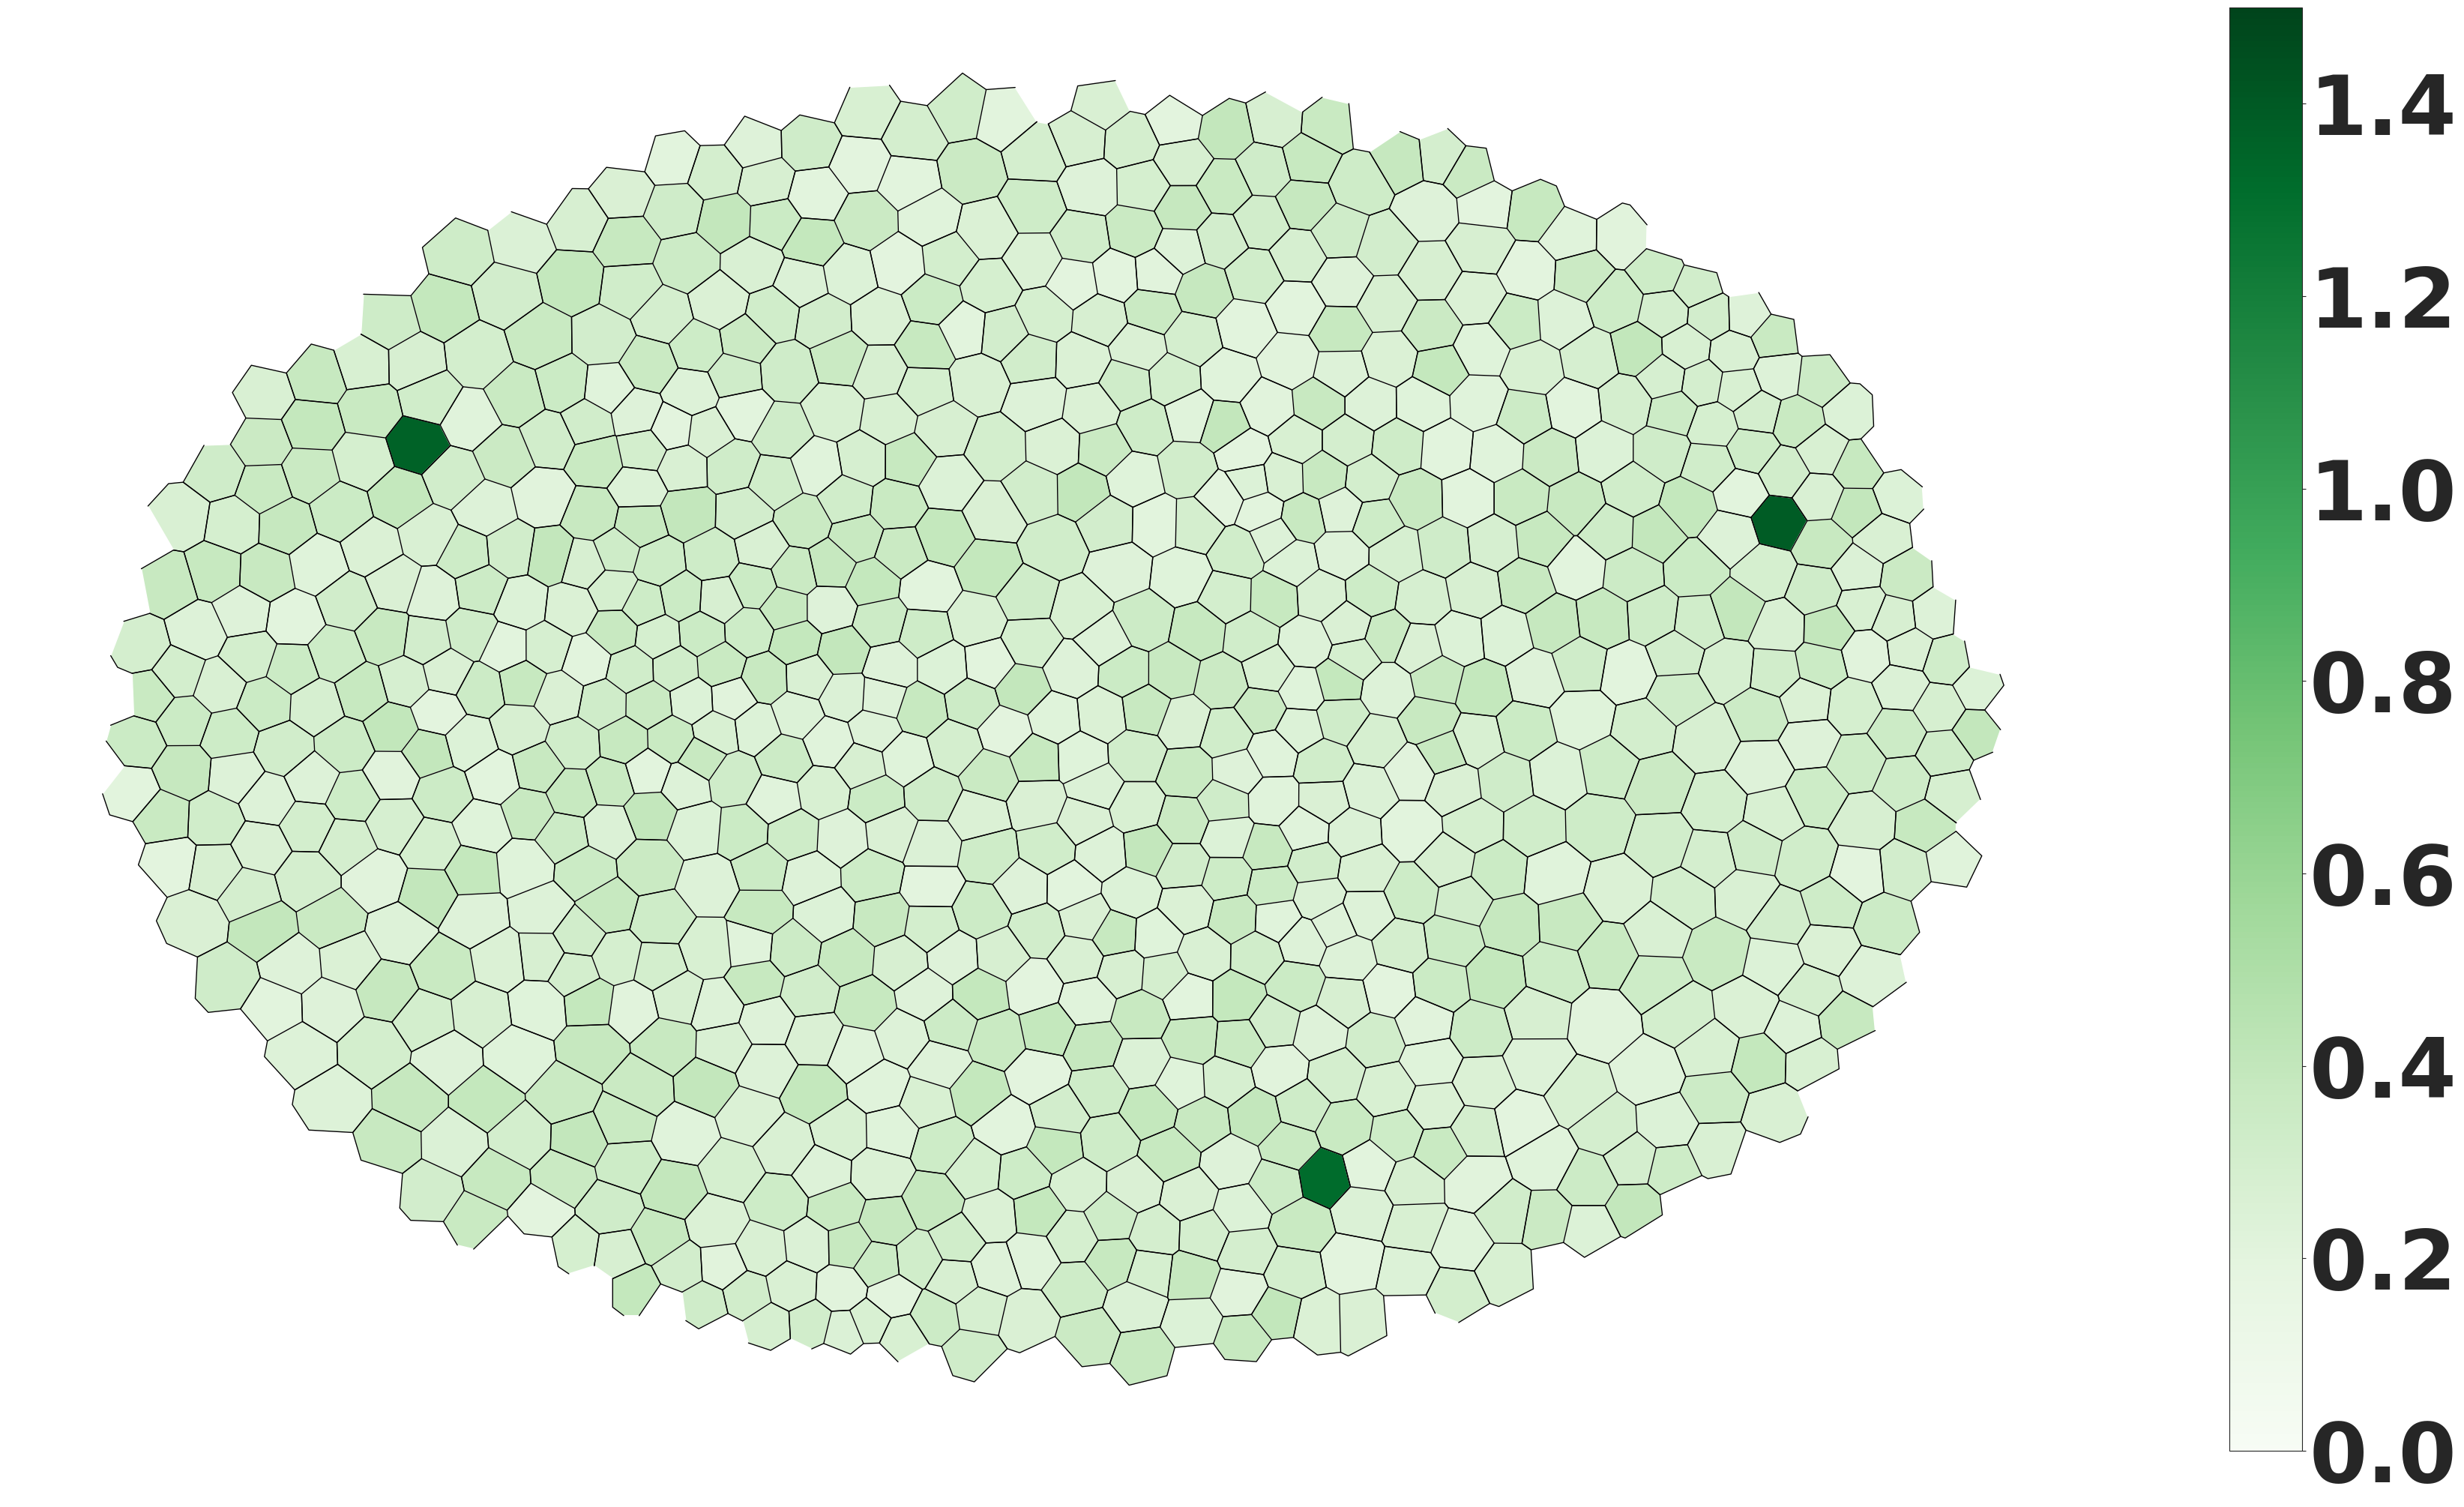

In [41]:
# Draw the VPLC profile for the simulation
p_Spikes_opt_dt.draw_profile(path=saveFolderName)

In [54]:
# Define the alpha values for the simulations
alpha_values = [0, 0.14 ]  # Different alpha values for testing

# Run simulations for each alpha value and store the results
simulations = {'Spikes': []}
for alpha in alpha_values:
    sim_params = sim_params_Spikes.copy()
    sim_params['alpha'] = alpha
    sim = Pouch(params=sim_params, size='small', sim_number=12345, save=False, saveName=f'Spikes_alpha_{alpha}_dt')
    sim.simulate_optogenetic_dt()
    sim.count_spiking_cells()  # Count the number of spiking cells
    print(f"Alpha: {alpha}, Spiking cells: {sim.count_spiking_cells()}, Spiking cell index: {np.where(np.max(sim.disc_dynamics[:, 0, :], axis=1) > 0.5)[0]}")
    simulations['Spikes'].append(sim)


Alpha: 0, Spiking cells: 3, Spiking cell index: [ 82 596 809]
Alpha: 0.14, Spiking cells: 21, Spiking cell index: [ 27  66  77  82 134 191 206 233 300 404 446 522 539 556 596 749 752 790
 809 834 858]


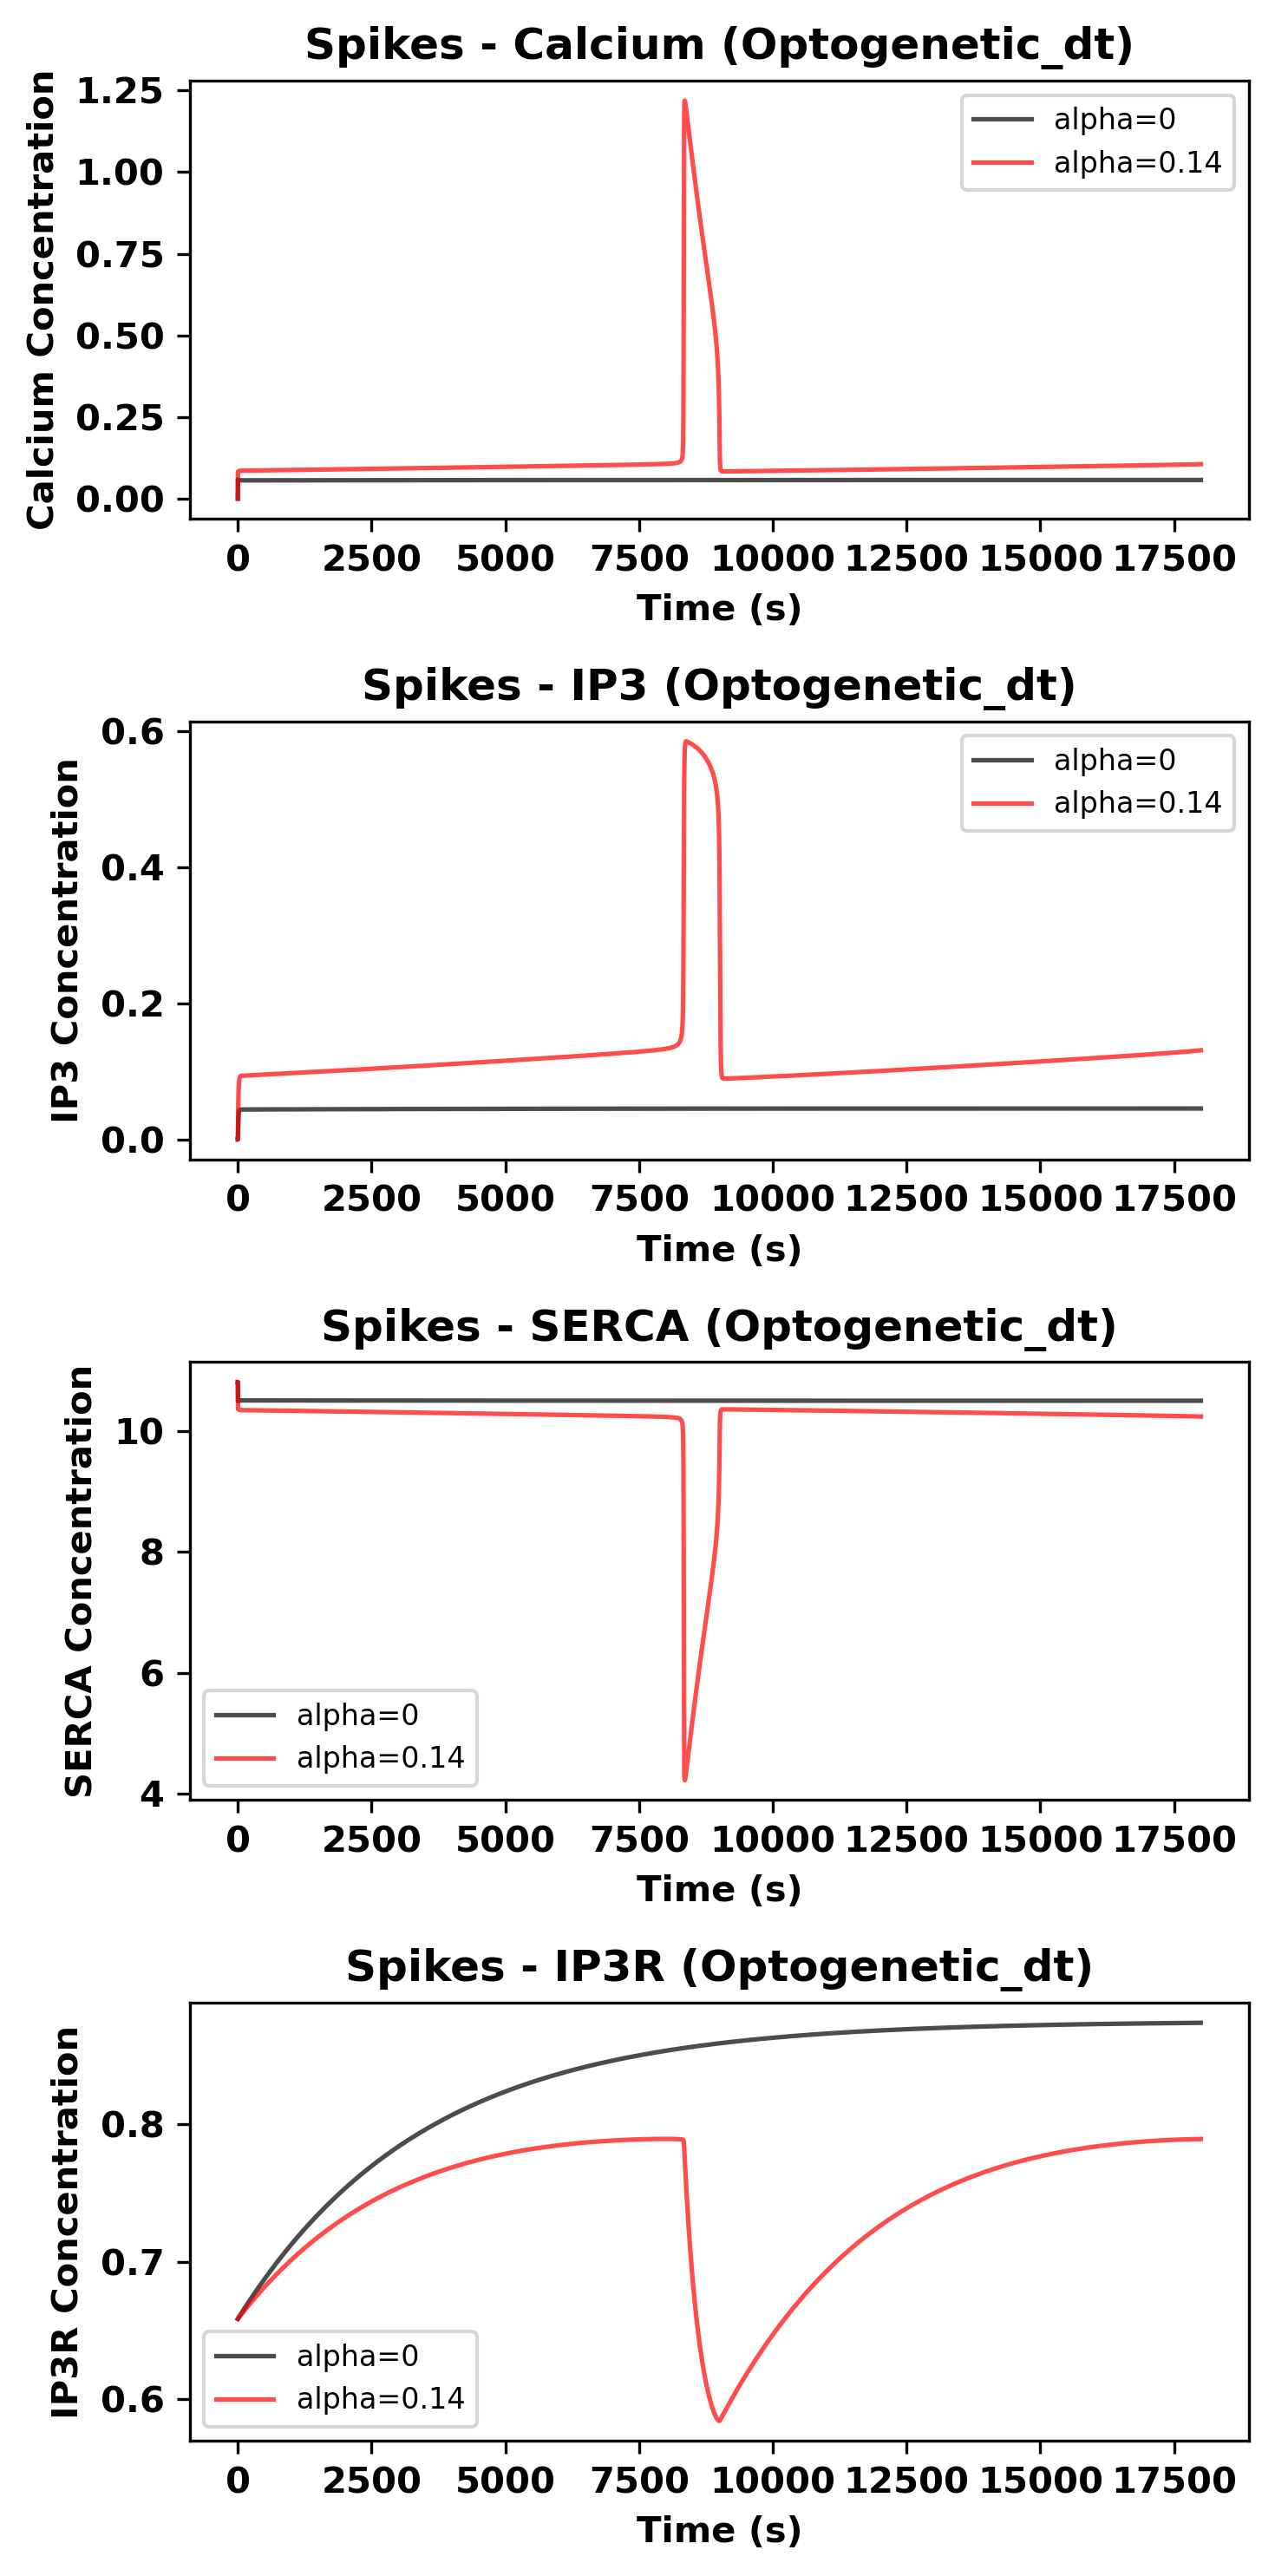

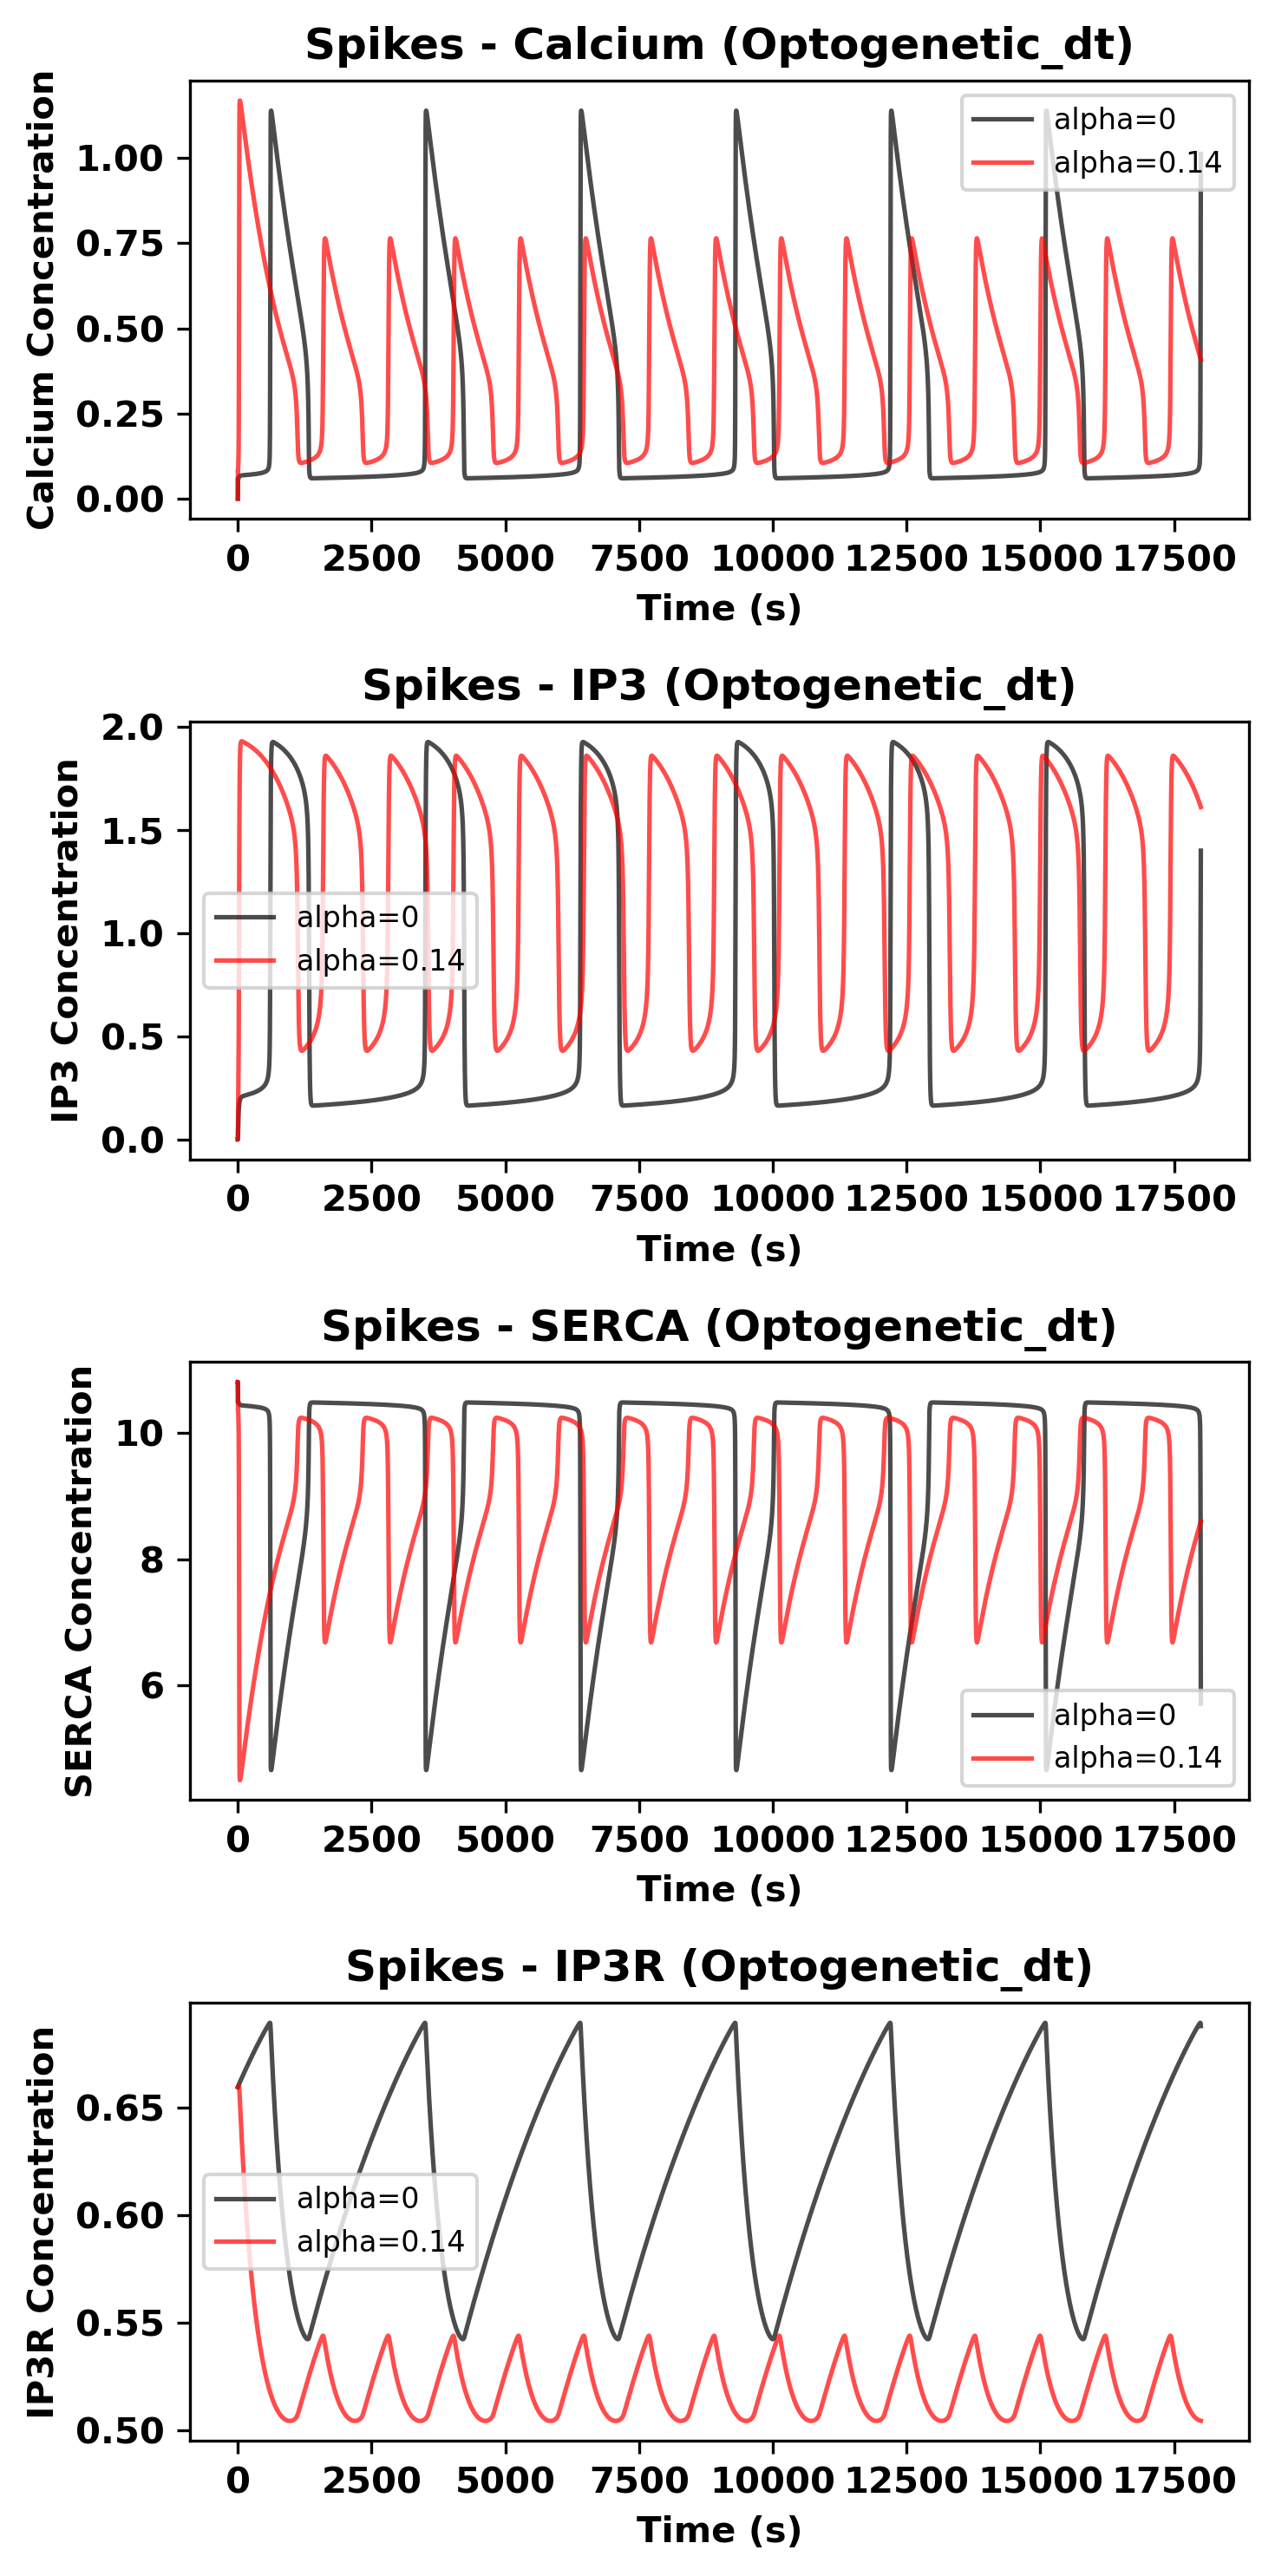

In [55]:
# Plot calcium, IP3, SERCA, and IP3R dynamics for different alpha values (optogenetic_dt version)
state_labels = ['Calcium', 'IP3', 'SERCA', 'IP3R']
cell_indices = [77, 596]
custom_colors = ['black', 'red', 'blue', 'orange', 'green']


for cell_index in cell_indices:
    fig, axes = plt.subplots(4, 1, figsize=(5, 10), dpi=300)  # Adjusted for a single column

    for row, label in enumerate(state_labels):
        ax = axes[row]  # Get the current axis

        for i, alpha in enumerate(alpha_values):
            dynamics = simulations['Spikes'][i].disc_dynamics[cell_index, row, :]
            color = custom_colors[i % len(custom_colors)]  # Cycle through colors if more alpha values than colors
            ax.plot(dynamics, label=f'alpha={alpha}', alpha=0.7, color=color, linewidth=1.25)

        ax.set_title(f'Spikes - {label} (Optogenetic_dt)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=10, fontweight='bold')  # Bold X-axis label
        ax.set_ylabel(f'{label} Concentration', fontsize=10, fontweight='bold')  # Bold Y-axis label

        # Make x and y ticks bold
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontweight('bold')
            tick.set_fontsize(10)

        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(sim_folder_path, 'Spikes_dynamics_vs_alpha.svg'), transparent=True)
    plt.savefig(os.path.join(sim_folder_path, 'Spikes_dynamics_vs_alpha.png'), transparent=True)
    plt.show()


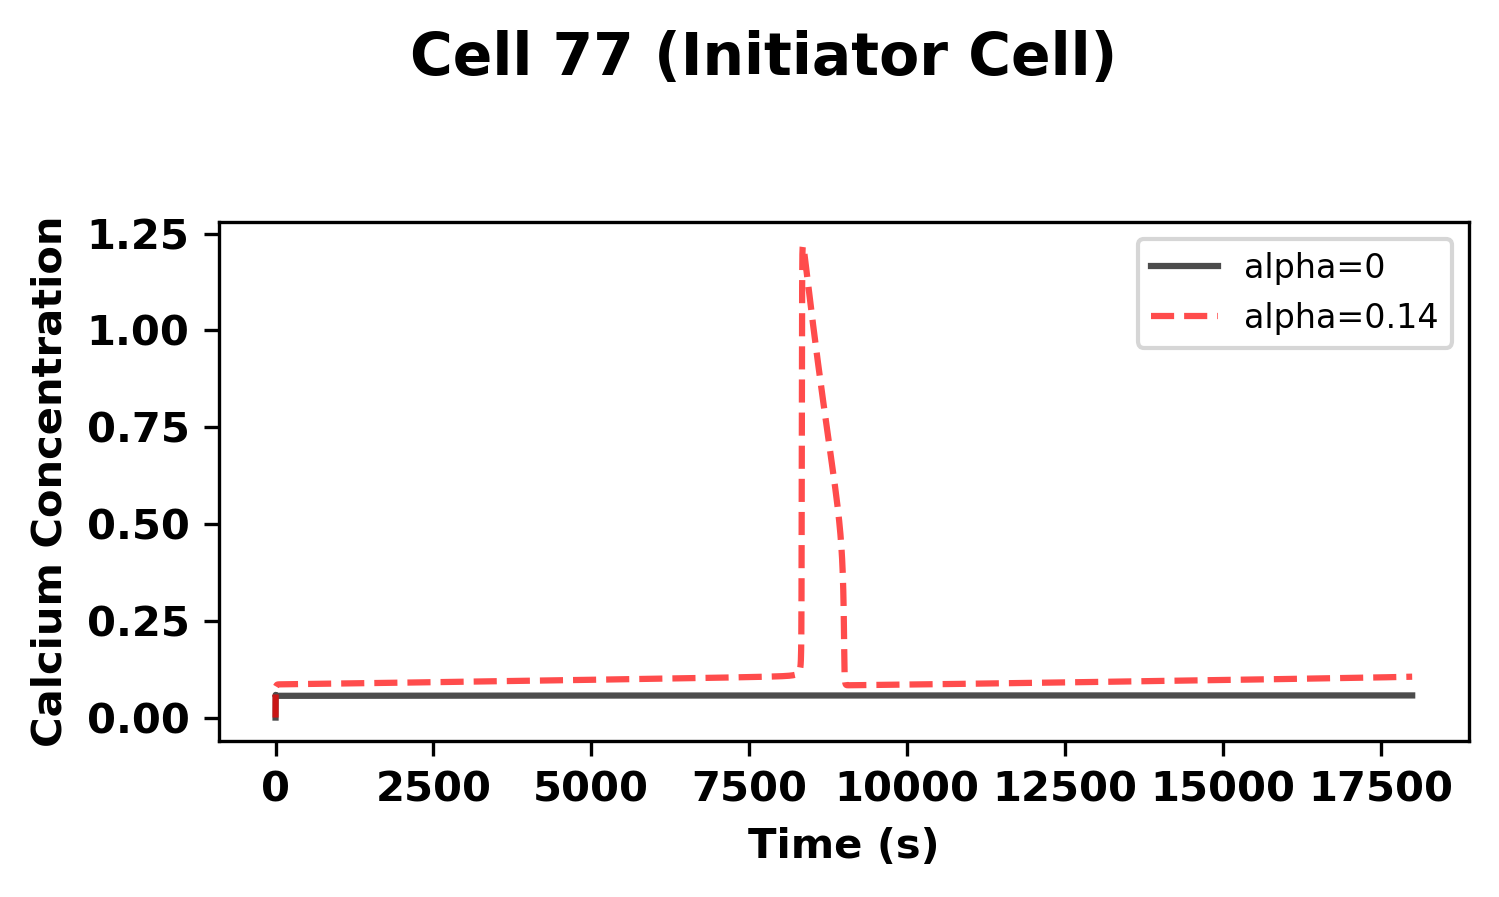

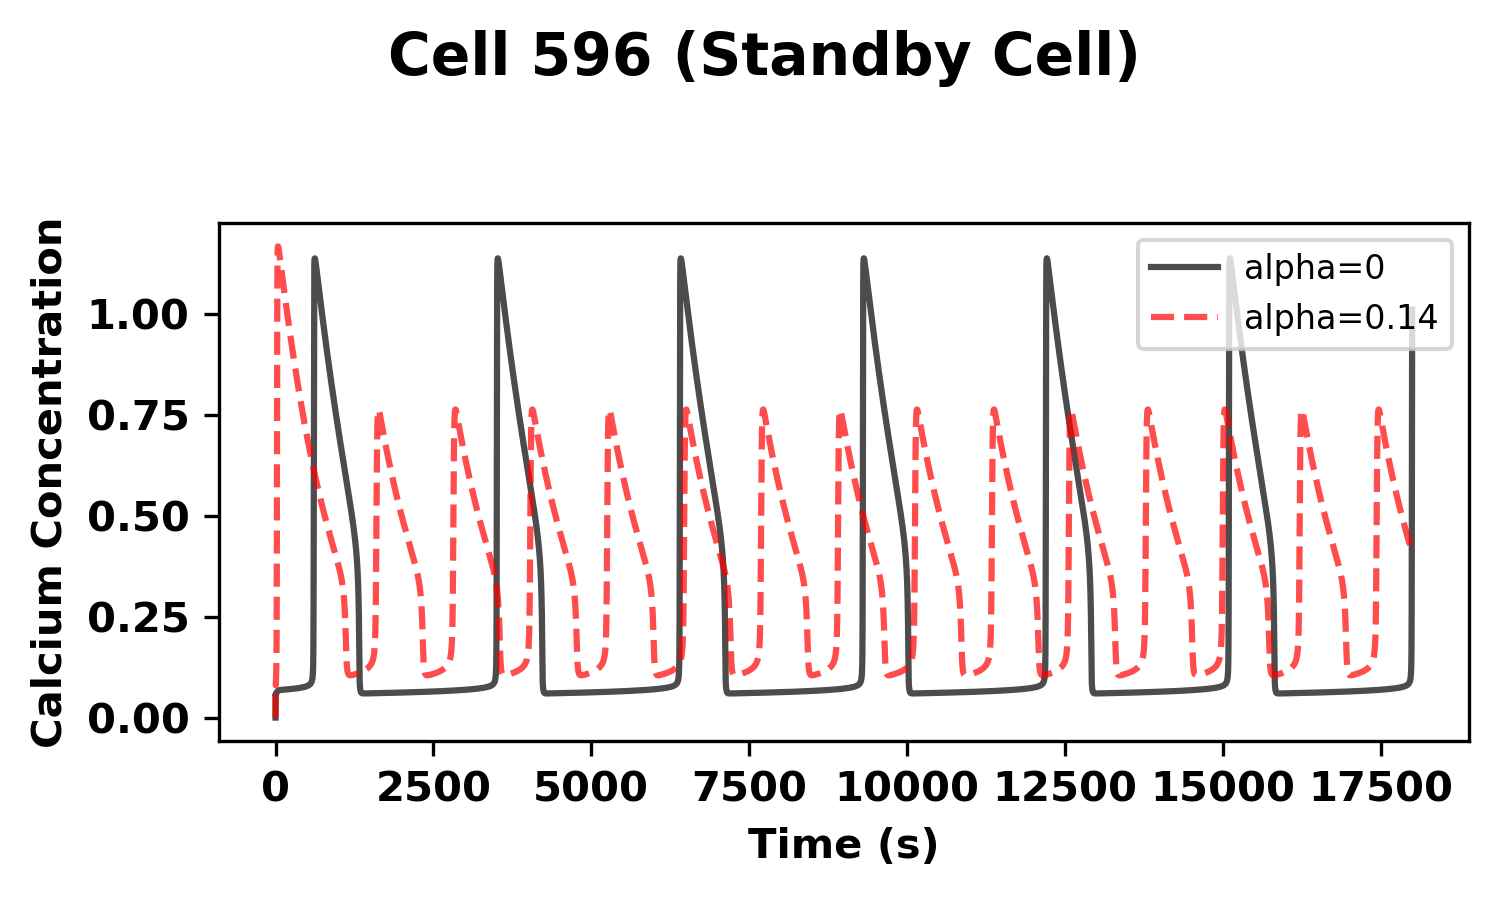

In [58]:
# Only plot calcium (state 0), remove subplot titles, and add custom figure titles with cell indices and cell type info

cell_indices = [77, 596]
custom_colors = ['black', 'red', 'blue', 'orange', 'green']

for idx, cell_index in enumerate(cell_indices):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
    for i, alpha in enumerate(alpha_values):
        dynamics = simulations['Spikes'][i].disc_dynamics[cell_index, 0, :]
        color = custom_colors[i % len(custom_colors)]
        # Use a different marker and linestyle for each line
        linestyle = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))][i % 5]
        ax.plot(
            dynamics,
            label=f'alpha={alpha}',
            alpha=0.7,
            color=color,
            linewidth=1.5,
            linestyle=linestyle
        )

    ax.set_xlabel('Time (s)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Calcium Concentration', fontsize=10, fontweight='bold')

    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(10)

    ax.legend(fontsize=8)

    # Custom figure title
    if idx == 0:
        fig_title = f'Cell {cell_index} (Initiator Cell)'
    else:
        fig_title = f'Cell {cell_index} (Standby Cell)'
    plt.suptitle(fig_title, fontsize=14, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(os.path.join(sim_folder_path, f'Spikes_Calcium_Cell_{cell_index}.svg'), transparent=True)
    plt.savefig(os.path.join(sim_folder_path, f'Spikes_Calcium_Cell_{cell_index}.png'), transparent=True)
    plt.show()

In [45]:
import numpy as np
from scipy.signal import find_peaks

def compute_spiking_cell_counts_with_indices(sim_gap, sim_no_gap, threshold=0.5, prominence=0.05):
    """
    Count spiking cells and return their indices using scipy peak detection.

    Parameters:
        sim_gap: Pouch object with gap junctions.
        sim_no_gap: Pouch object without gap junctions.
        threshold: float, calcium level threshold for peak detection.
        prominence: float, minimum prominence to qualify as a spike.

    Returns:
        Tuple:
        - Number of spiking cells with gap junctions
        - Number of spiking cells without gap junctions
        - Indices of spiking cells in gap case
        - Indices of spiking cells in no-gap case
    """
    n_cells = sim_gap.disc_dynamics.shape[0]
    spiking_gap_indices = []
    spiking_no_gap_indices = []

    for i in range(n_cells):
        ca_trace_gap = sim_gap.disc_dynamics[i, 0, :]
        ca_trace_no_gap = sim_no_gap.disc_dynamics[i, 0, :]

        peaks_gap, _ = find_peaks(ca_trace_gap, height=threshold, prominence=prominence)
        peaks_no_gap, _ = find_peaks(ca_trace_no_gap, height=threshold, prominence=prominence)

        if len(peaks_gap) > 0:
            spiking_gap_indices.append(i)
        if len(peaks_no_gap) > 0:
            spiking_no_gap_indices.append(i)

    return (len(spiking_gap_indices), len(spiking_no_gap_indices),
            spiking_gap_indices, spiking_no_gap_indices)


In [46]:
# Make a simpler version of the function to compute initiator fractions one at a time
def compute_initiator_fractions_single(sim_gap, sim_no_gap, threshold=0.5):
    """
    Count the number of initiator cells that spike in both the gap and no-gap versions of a simulation.

    Parameters:
        sim_gap: Pouch object for the gap version of the simulation.
        sim_no_gap: Pouch object for the no-gap version of the simulation.
        threshold: float, the calcium concentration threshold for spiking.

    Returns:
        int: The number of initiator cells that spike in both versions.
    """
    # Identify cells that spike in the gap version
    spiking_cells_gap = set(np.where(np.max(sim_gap.disc_dynamics[:, 0, :], axis=1) > threshold)[0])
    
    # Identify cells that spike in the no-gap version
    spiking_cells_no_gap = set(np.where(np.max(sim_no_gap.disc_dynamics[:, 0, :], axis=1) > threshold)[0])
    
    # Find the intersection of the two sets
    common_spiking_cells = spiking_cells_gap.intersection(spiking_cells_no_gap)
    
    return len(common_spiking_cells), len(spiking_cells_gap), len(spiking_cells_no_gap)

In [47]:
import pandas as pd
import gc

# Define alpha values to vary from 10^-2.5 to 10^-1 (0.003 to 0.1)
alpha_values = np.logspace(-1.25, 0.01, 25)  # Logarithmic spacing for better resolution

# Update modifiable_params to include spike threshold and prominence for peak detection
modifiable_params = {
    'threshold': 0.25,  # Calcium concentration threshold for spiking
    'prominence': 0.05, # Prominence for peak detection
    'size': 'small',    # Size of the pouch
    'sim_number': 12345,  # Simulation number for reproducibility
    'save': True,         # Whether to save the results
    'save_folder': saveFolderName  # Folder to save results
}

# Create a dataframe to store the simulation results
results_df = pd.DataFrame(columns=[
    'alpha', 'fraction_initiators_gap', 'fraction_initiators_no_gap', 'fraction_initiators_both',
    'num_initiators_gap', 'num_initiators_no_gap', 'num_initiators_both',
    'num_spiking_gap', 'num_spiking_no_gap',
    'spiking_indices_gap', 'spiking_indices_no_gap'
])

for idx, alpha in enumerate(alpha_values):
    print(f"Simulating for alpha value {idx+1}/{len(alpha_values)}: {alpha:.4f}")
    # Gap simulations
    sim_params_gap = sim_params_Spikes.copy()
    sim_params_gap['alpha'] = alpha
    sim_gap = Pouch(params=sim_params_gap, size=modifiable_params['size'], sim_number=modifiable_params['sim_number'], save=modifiable_params['save'], saveName=f'Spikes_alpha_{alpha:.4f}')
    sim_gap.simulate_optogenetic_dt()
    
    # No-gap simulations
    sim_params_no_gap = sim_params_gap.copy()
    sim_params_no_gap['D_p'] = 0
    sim_params_no_gap['D_c_ratio'] = 0
    sim_no_gap = Pouch(
        params=sim_params_no_gap,
        size=modifiable_params['size'],
        sim_number=modifiable_params['sim_number'],
        save=modifiable_params['save'],
        saveName=f'Spikes_alpha_{alpha:.4f}_no_gap'
    )
    sim_no_gap.simulate_optogenetic_dt()

    # Count initiator cells that spike in both versions
    n_both, n_gap, n_no_gap = compute_initiator_fractions_single(sim_gap, sim_no_gap, threshold=modifiable_params['threshold'])
    fraction_initiators_gap = n_gap / sim_gap.n_cells
    fraction_initiators_no_gap = n_no_gap / sim_gap.n_cells
    fraction_initiators_both = n_both / sim_gap.n_cells

    # Count spiking cells and get their indices using peak detection
    num_spiking_gap, num_spiking_no_gap, spiking_indices_gap, spiking_indices_no_gap = compute_spiking_cell_counts_with_indices(
        sim_gap, sim_no_gap, threshold=modifiable_params['threshold'], prominence=modifiable_params['prominence']
    )

    # Store the results
    results_df = pd.concat(
        [results_df, pd.DataFrame({
            'alpha': [alpha],
            'fraction_initiators_gap': [fraction_initiators_gap],
            'fraction_initiators_no_gap': [fraction_initiators_no_gap],
            'fraction_initiators_both': [fraction_initiators_both],
            'num_initiators_gap': [n_gap],
            'num_initiators_no_gap': [n_no_gap],
            'num_initiators_both': [n_both],
            'num_spiking_gap': [num_spiking_gap],
            'num_spiking_no_gap': [num_spiking_no_gap],
            'spiking_indices_gap': [spiking_indices_gap],
            'spiking_indices_no_gap': [spiking_indices_no_gap]
        })],
        ignore_index=True
    )

    # Delete the simulation objects to free memory
    del sim_gap
    del sim_no_gap
    gc.collect()


Simulating for alpha value 1/25: 0.0562
Simulating for alpha value 2/25: 0.0635
Simulating for alpha value 3/25: 0.0716
Simulating for alpha value 4/25: 0.0808
Simulating for alpha value 5/25: 0.0912
Simulating for alpha value 6/25: 0.1029
Simulating for alpha value 7/25: 0.1161
Simulating for alpha value 8/25: 0.1311
Simulating for alpha value 9/25: 0.1479
Simulating for alpha value 10/25: 0.1669
Simulating for alpha value 11/25: 0.1884
Simulating for alpha value 12/25: 0.2126
Simulating for alpha value 13/25: 0.2399
Simulating for alpha value 14/25: 0.2707
Simulating for alpha value 15/25: 0.3055
Simulating for alpha value 16/25: 0.3447
Simulating for alpha value 17/25: 0.3890
Simulating for alpha value 18/25: 0.4390
Simulating for alpha value 19/25: 0.4955
Simulating for alpha value 20/25: 0.5591
Simulating for alpha value 21/25: 0.6310
Simulating for alpha value 22/25: 0.7120
Simulating for alpha value 23/25: 0.8035
Simulating for alpha value 24/25: 0.9068
Simulating for alpha valu

In [48]:

# Save the results including spike indices
# results_df.to_pickle(os.path.join(modifiable_params['save_folder'], 'initiator_fractions_results_with_spike_indices.pkl'))
results_df.to_csv(os.path.join(modifiable_params['save_folder'], 'initiator_fractions_results_with_spike_indices_new.csv'), index=False)


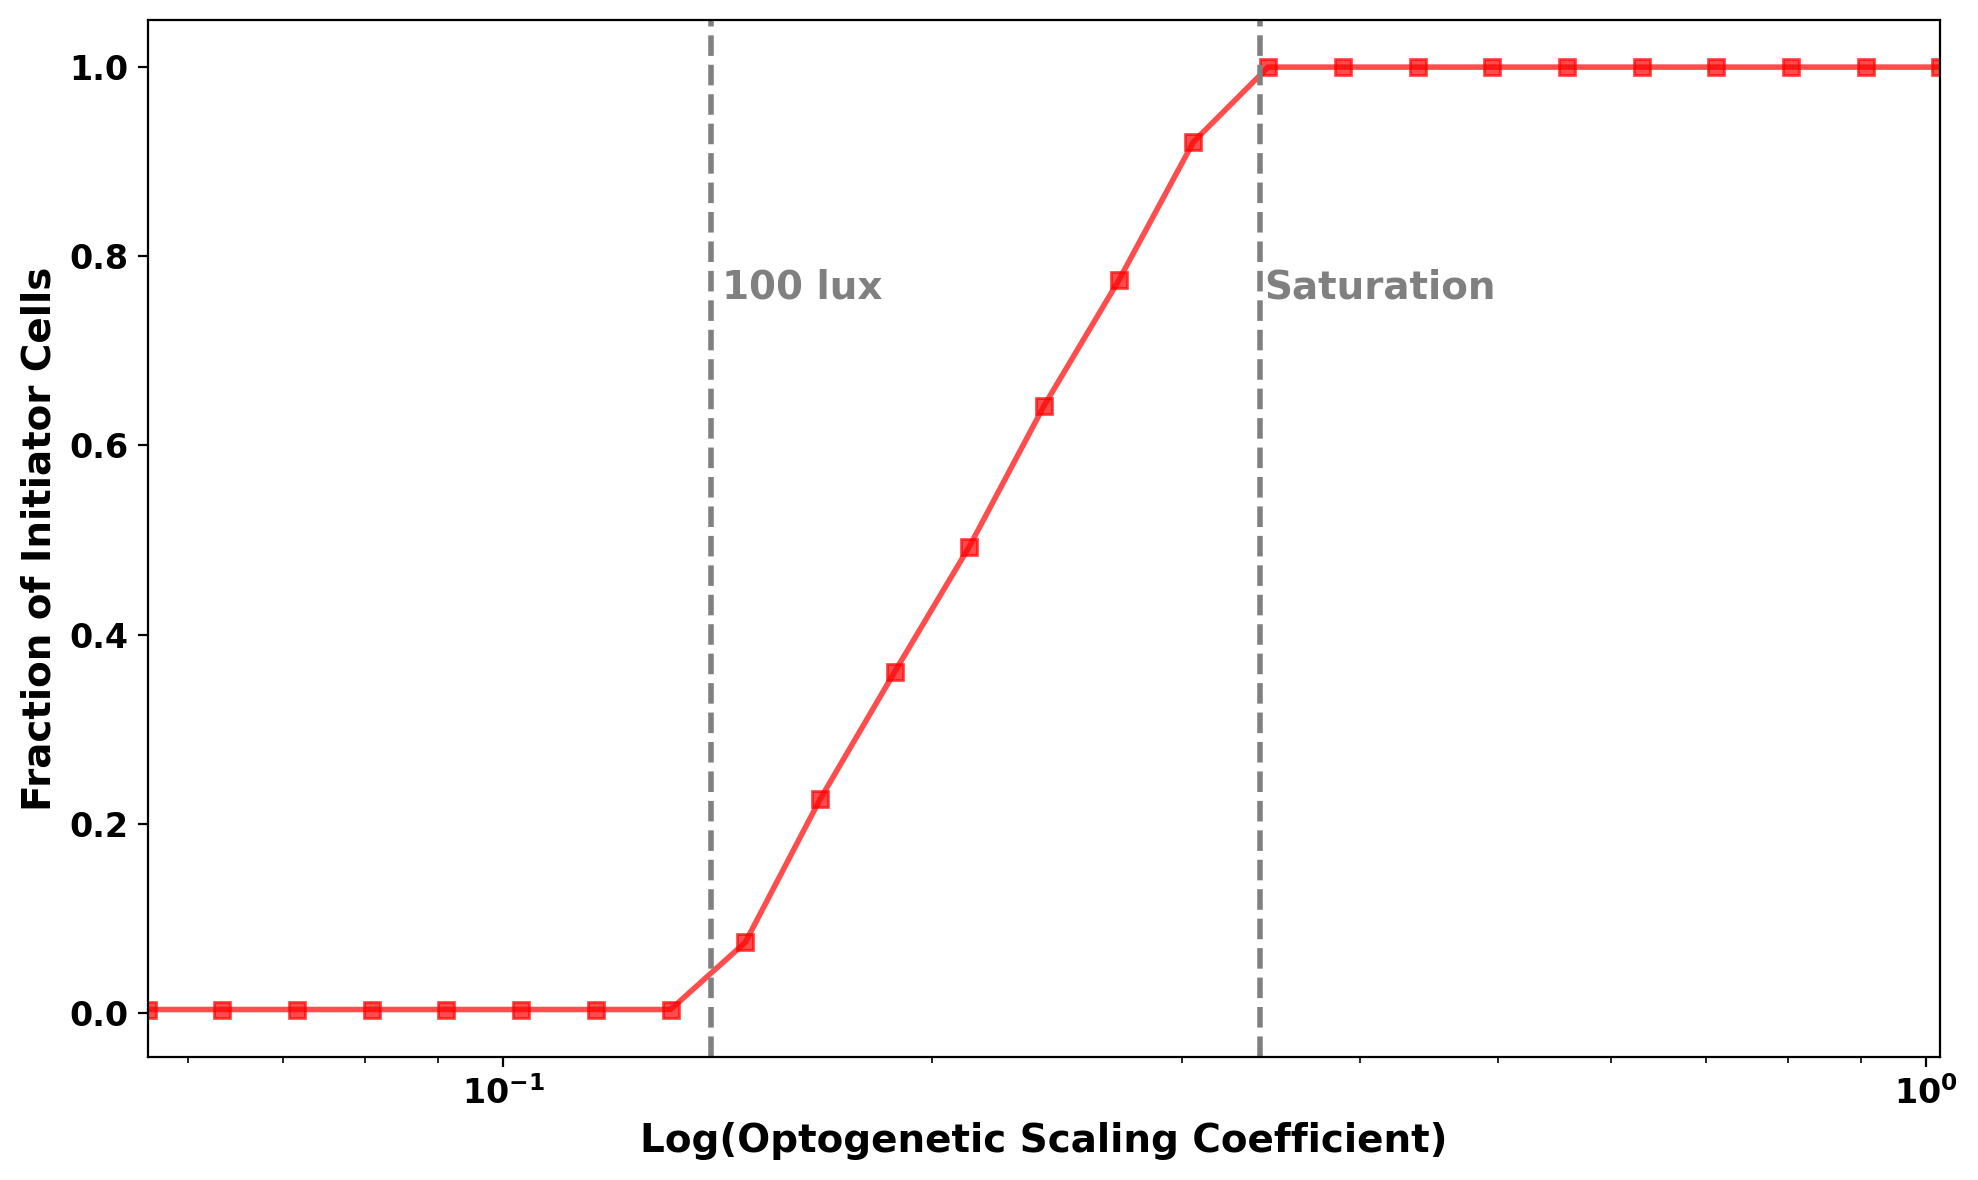

In [71]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)



# Define a consistent color order


# Plotting with specified colors, markers, and increased linewidth

ax.plot(results_df['alpha'], results_df['fraction_initiators_no_gap'], label='No Gap', color=custom_colors[1], marker='s', alpha=0.7, linewidth=2, markersize=6)

ax.set_xscale('log')
# ax.set_title('Initiator Fractions vs Alpha', fontsize=16, fontweight='bold')
ax.set_xlabel('Log(Optogenetic Scaling Coefficient)', fontsize=14, fontweight='bold')
ax.set_ylabel('Fraction of Initiator Cells', fontsize=14, fontweight='bold')

# Make x and y ticks bold with larger fontsize
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_fontsize(12)

# ax.legend(fontsize=12)
# ax.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
# Set the x-axis limits
ax.set_xlim([min(results_df['alpha']), max(results_df['alpha'])])

# Add vertical line at alpha = 0.04 and label it "100 lux"
ax.axvline(x=0.14, color='gray', linestyle='--', linewidth=2)
ax.text(0.1425, ax.get_ylim()[1]*0.75, '100 lux', color='gray', fontsize=14, fontweight='bold', rotation=0, ha='left', va='top')

ax.axvline(x=0.34, color='gray', linestyle='--', linewidth=2)
ax.text(0.3425, ax.get_ylim()[1]*0.75, 'Saturation', color='gray', fontsize=14, fontweight='bold', rotation=0, ha='left', va='top')

plt.tight_layout()

# Save the figure with transparent background
plt.savefig(os.path.join(sim_folder_path, 'Initiator_Fractions_vs_Alpha_small.svg'), transparent=True)
plt.savefig(os.path.join(sim_folder_path, 'Initiator_Fractions_vs_Alpha_small.png'), transparent=True)

plt.show()
